In [1]:
import Pkg
Pkg.activate(@__DIR__)

  Activating project at `/storage/work/s/suv87/julia/invariance`


In [2]:
using LinearAlgebra, Plots, ProgressMeter, Pipe
using Random, Statistics, Distributions
using Ripserer, PersistenceDiagrams

In [3]:
function generate_random_psd_matrix(n::Int, d::Int)
U, _ = qr(randn(n, n))
D = Diagonal([[rand() for i = 1:d]...; 0.01 .+ zeros(n-d)...])
A = U * D * U'
return Symmetric(A)
end

function rand_chisq(A, B; vec = rand(4))
    vec = sqrt.(sum(vec) ./ vec)
    x = randn(size(A, 1))
    s, t = sign.(x)'
    if s < 0 && t < 0
        u, v = s * (x'A*x), t * (x'B*x)
        u, v = (u, v) ./ vec[1]
    elseif s < 0 && t > 0
        u, v = s * (x'A*x), t * (x'B*x)
        u, v = (u, v) ./ vec[2]
    elseif s > 0 && t < 0
        u, v = s * (x'A*x), t * (x'B*x)
        u, v = (u, v) ./ vec[3]
    elseif s > 0 && t > 0
        u, v = s * (x'A*x), t * (x'B*x)
        u, v = (u, v) ./ vec[4]
end
    return (u, v)
end

rand_chisq (generic function with 1 method)

[0.46 0.47 0.03 0.04; 0.17 0.39 0.21 0.24]


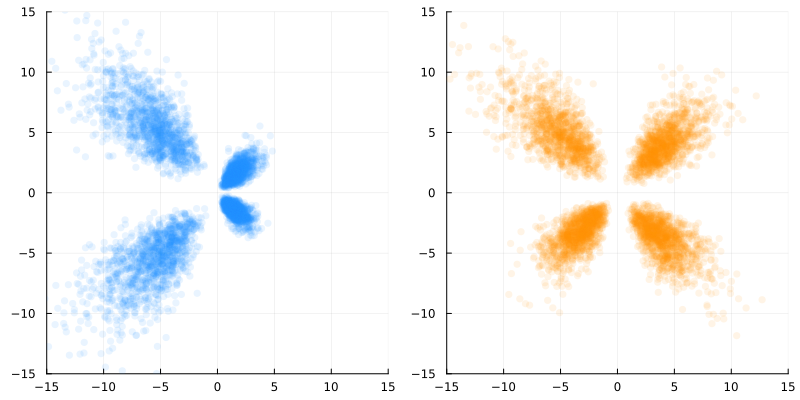

In [63]:
Random.seed!(314159)
v1, v2 = rand(4), rand(4)
A = generate_random_psd_matrix(20, 15)
B = generate_random_psd_matrix(20, 15)
x, y = [rand_chisq(A, B; vec=v1) for _ in 1:5000], [rand_chisq(A, B; vec=v2) for _ in 1:5000]

println(@pipe [v1 ./ sum(v1) v2 ./ sum(v2)] .|> round(_, digits=2) |> transpose)


plot_scatter_1 = scatter(x, ma=0.1, msw=0, label="", lim=(-15, 15), c=:dodgerblue, size=(400, 400))
plot_scatter_2 = scatter(y, ma=0.1, msw=0, label="", lim=(-15, 15), c=:darkorange, size=(400, 400))
plot(plot_scatter_1, plot_scatter_2, size=(800, 400))

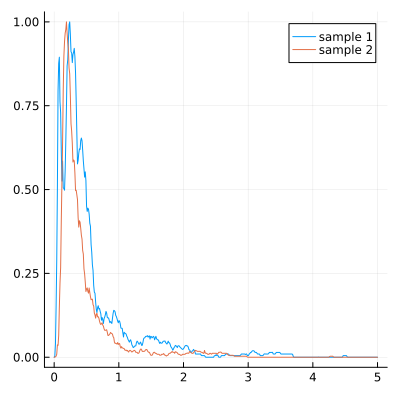

In [64]:
xs = range(0, 5, length=500)
d1, d2 = ripserer(Alpha(x), dim_max=1), ripserer(Alpha(y), dim_max=1)
c1, c2 = BettiCurve(extrema(xs)..., length = length(xs)).((d1[2], d2[2]))
plot_curve = plot(xs, c1 ./ maximum(c1), label="sample 1")
plot_curve = plot(plot_curve, xs, c2 ./ maximum(c2), label="sample 2", size=(400, 400))
plot_curve

---

In [6]:
function one_sim(n; k=20, d=15, dim=1, seq=range(0, 1, length=100))
	A = generate_random_psd_matrix(k, d)
	x = [rand_chisq(A, B; vec=rand(4)) for _ in 1:n]
	D = ripserer(Alpha(x), dim_max=1)
	curve = BettiCurve(extrema(seq)..., length = length(seq))
	b = curve(D[1 + dim])
	return b
end

one_sim (generic function with 1 method)

In [41]:
function plt(B; normalize=true, seq=range(0, 1, length=10)
	M = 1
	if normalize
		M = maximum(maximum.(B))
	end
	p = plot(seq, 0, label="")
	for i in eachindex(B)
		p = plot(p, seq, B[i] ./ M, label="", lw=2, la=0.1, c=:black)
	end
	return p
end


function combined_plt(Bs; normalize=true, seq=range(0, 1, length=100), labs=N)
	p = plot(seq, 0, label="")
	cls = distinguishable_colors(1+length(Bs), colorant"black")[[1; 3:end]]
	for j in eachindex(Bs)
		M = 1
		if normalize
			M = maximum(maximum.(Bs[j]))
		end
		B = Bs[j] ./ M
		mean_B = [mean([B[k][i] for k in eachindex(B)]) for i in eachindex(seq)]
		p = plot(p, seq, mean_B, lw=2, la=1, c=cls[j], label="n=$(labs[j])")
		for i in eachindex(Bs[j])
			p = plot(p, seq, Bs[j][i] ./ M, label="", lw=1, la=0.2, c=cls[j])
		end
	end
	return p
end

combined_plt (generic function with 1 method)

---

In [8]:
N = [1000, 5_000, 10_000]
k, d = 20, 15
reps = 50
x_seq = range(0, 4, length=200)

0.0:0.020100502512562814:4.0

In [9]:
X = @showprogress [[one_sim(n; k=k, d=d, dim=1, seq=x_seq) for _ in 1:reps] for n in N];

Progress: 100%|█████████████████████████████████████████| Time: 0:01:31


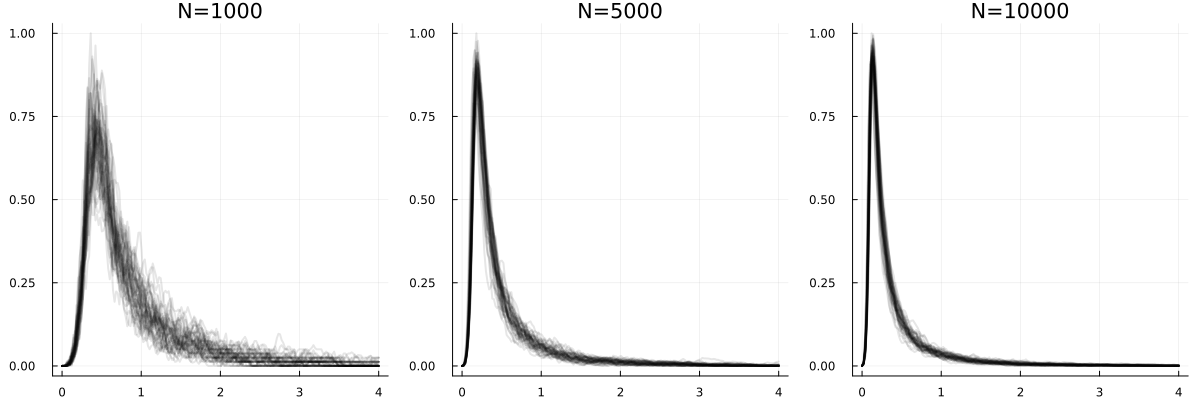

In [10]:
plot(
    plt.(X, seq=x_seq, normalize=true)..., 
    layout=(1, size(N, 1)), 
    title = ["N=$n" for n in reshape(N, 1, :)],
    size=(400 * size(N, 1), 400)
)

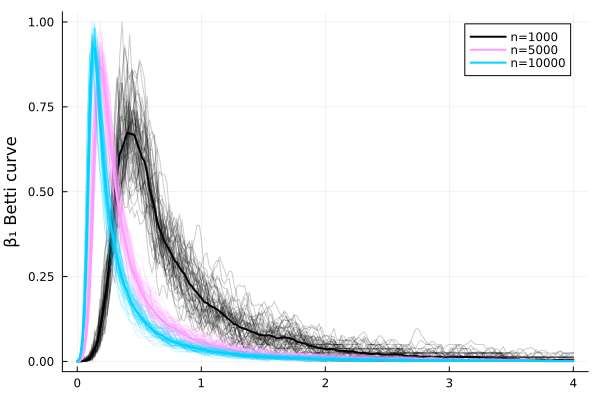

In [ ]:
combined_plt(X, seq=x_seq, normalize=true, labs=N)

---

In [44]:
savefig(plot_scatter_1, "./plots/example_scatter_1.pdf")
savefig(plot_scatter_2, "./plots/example_curve.pdf")
savefig(plot_curve, "./plots/example_curve.pdf")

for i in eachindex(X)
    p = plt(X[i], seq=x_seq, normalize=true; title = "N=$(N[i])")
    plot(p, size=(400, 400), ylab="Normalized Betti Number (β₁)")
    savefig("./plots/betti_curve_$(N[i]).pdf")
end

p = combined_plt(X, seq=x_seq, normalize=true, labs=N)
plot(p, size=(400, 400), ylab="Normalized (β₁) Betti Number")
savefig("./plots/betti_curve_combined.pdf")